
=== Початковий стан середовища ===


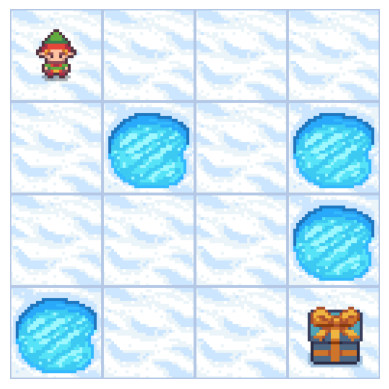


=== Виконання випадкових дій ===


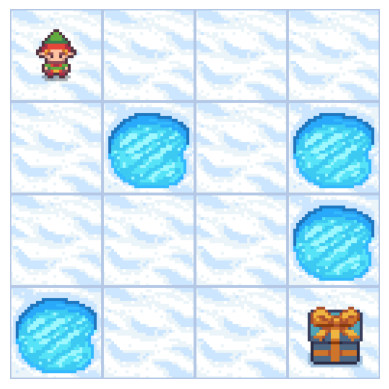

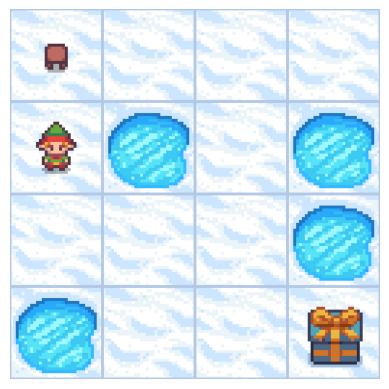

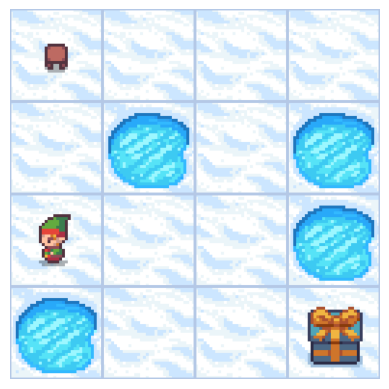

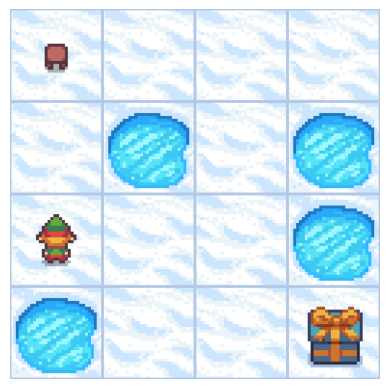

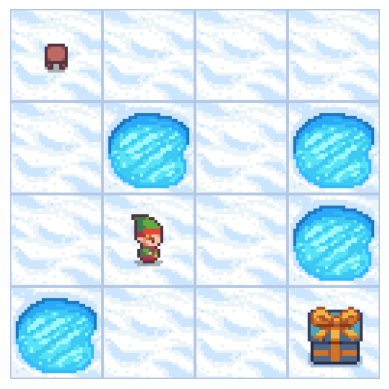

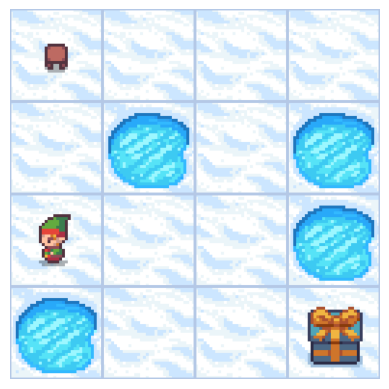

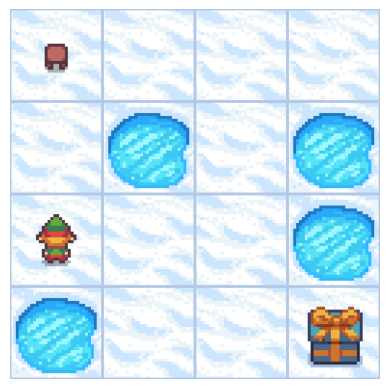

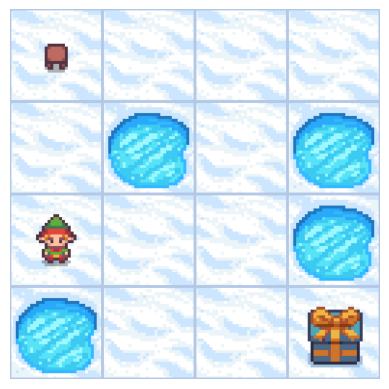

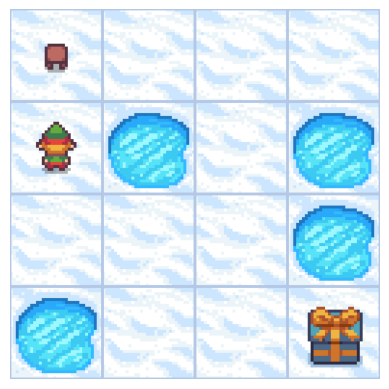

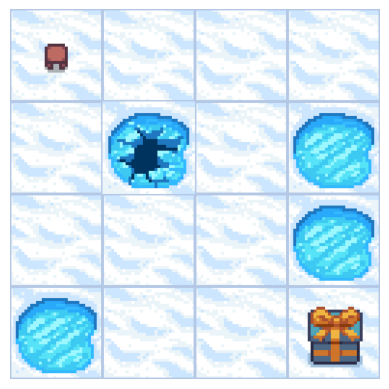


=== Ітерація за цінністю ===
Value-iteration converged at iteration# 1373.
Оптимальна функція цінності:
[0.82352941 0.82352941 0.82352941 0.82352941 0.82352941 0.
 0.52941176 0.         0.82352941 0.82352941 0.76470588 0.
 0.         0.88235294 0.94117647 0.        ]
Оптимальна політика:
[0. 3. 3. 3. 0. 0. 0. 0. 3. 1. 0. 0. 0. 2. 1. 0.]

=== Середовище після ітерації за цінністю ===


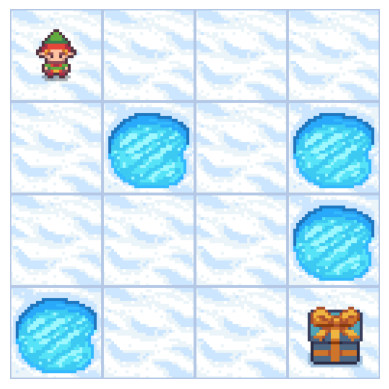


=== Ітерація за політиками ===
Policy-iteration converged at iteration# 7.
Оптимальна політика:
[0. 3. 3. 3. 0. 0. 0. 0. 3. 1. 0. 0. 0. 2. 1. 0.]

=== Середовище після ітерації за політиками ===


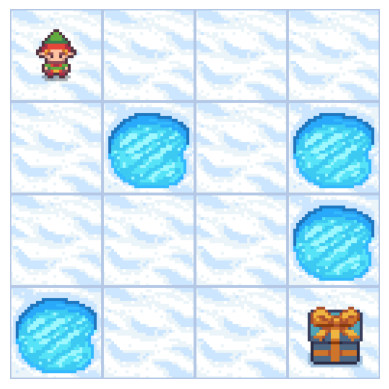


=== Виконання оптимальної політики ===


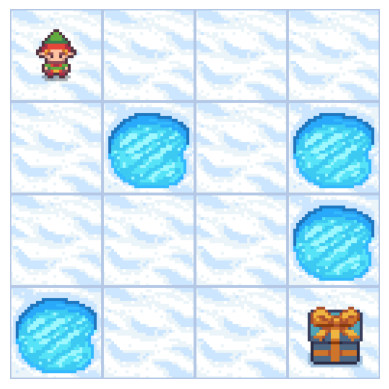

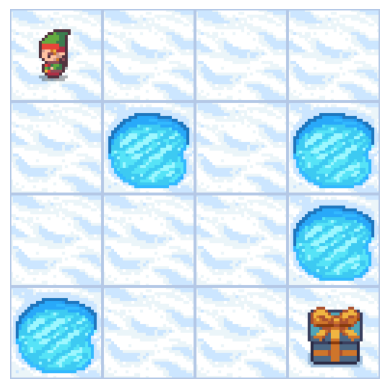

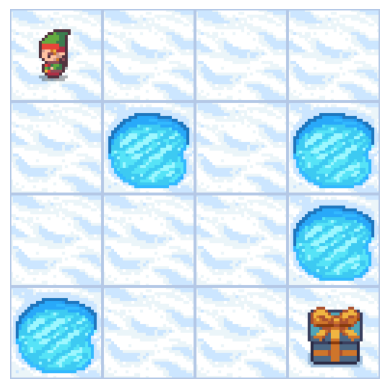

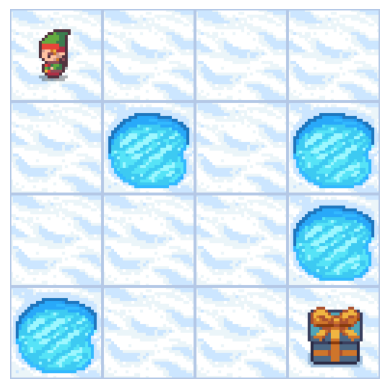

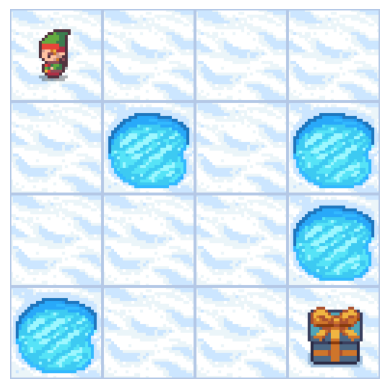

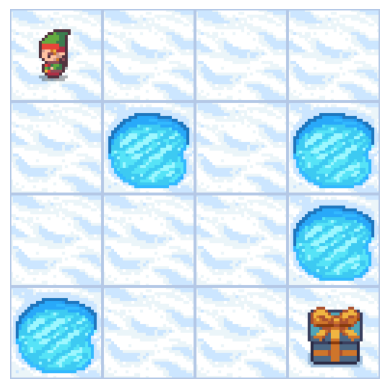

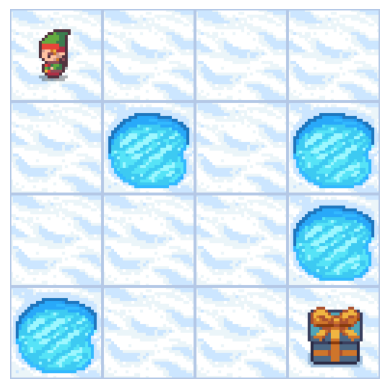

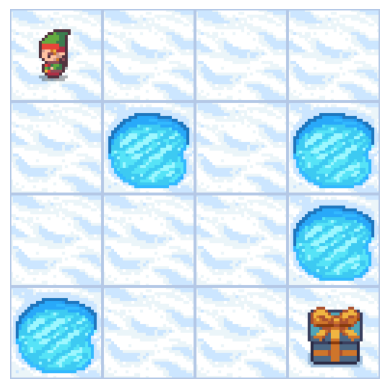

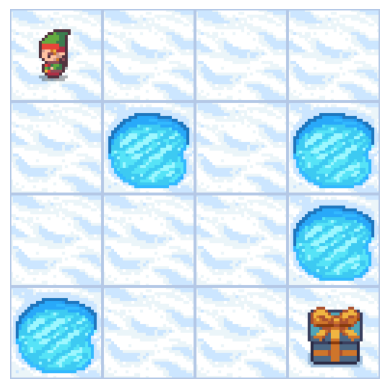

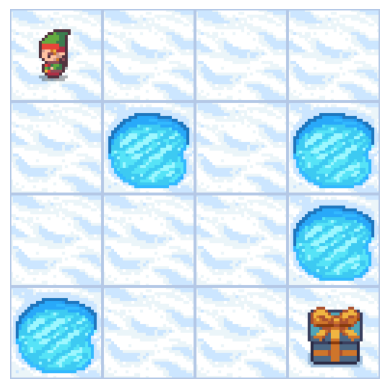

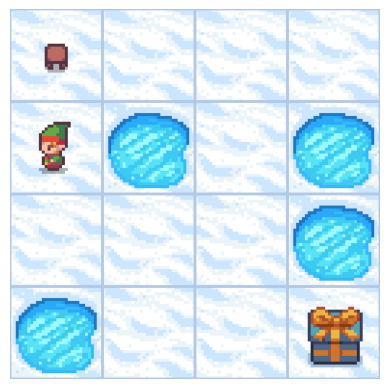

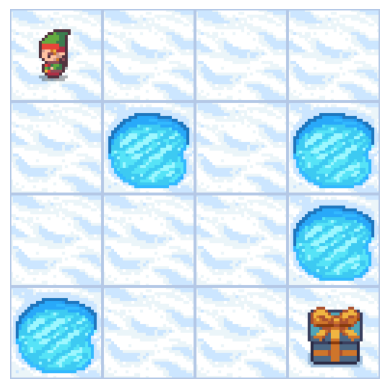

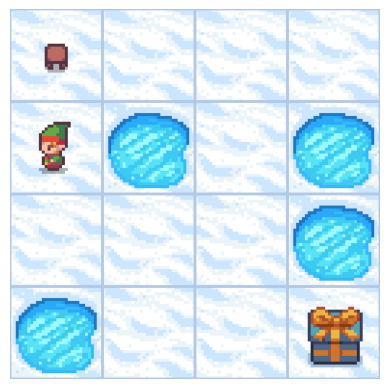

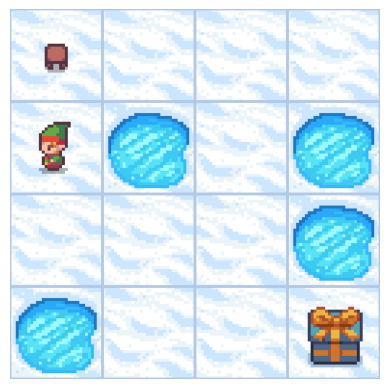

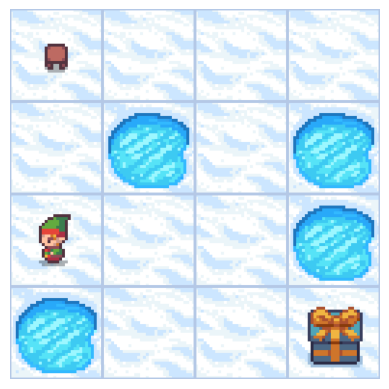

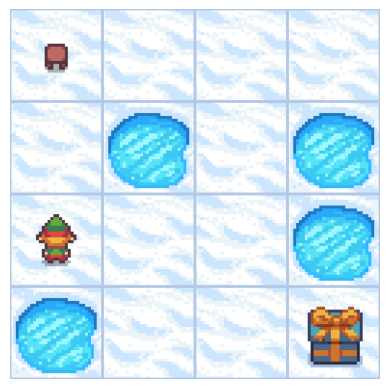

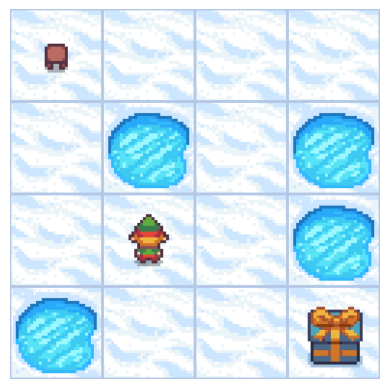

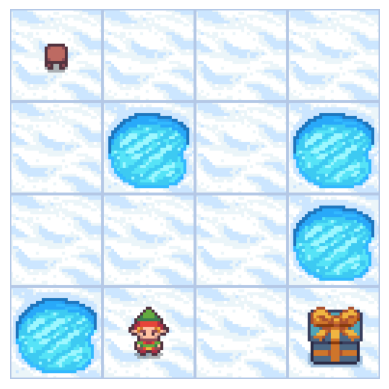

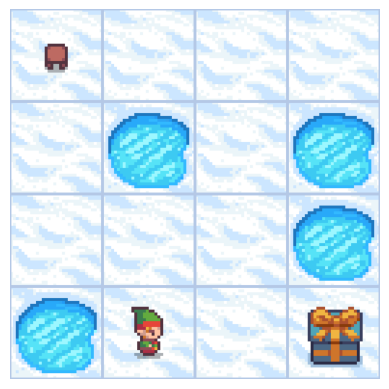

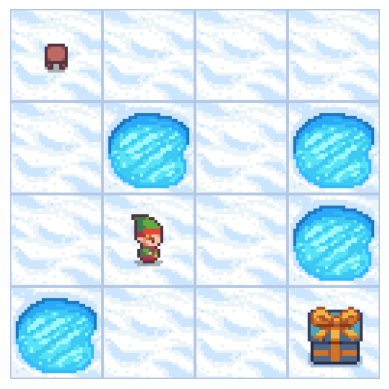

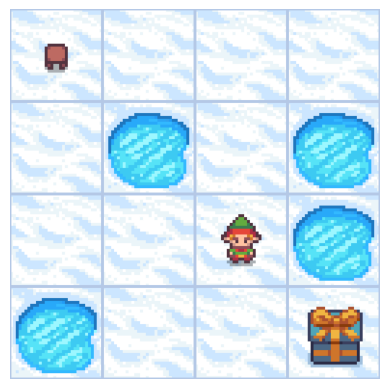

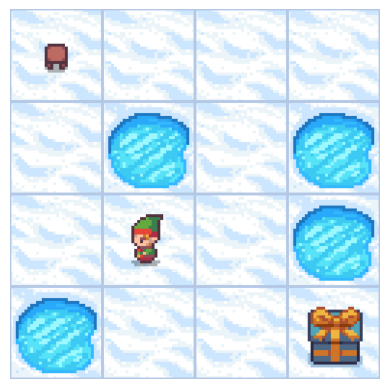

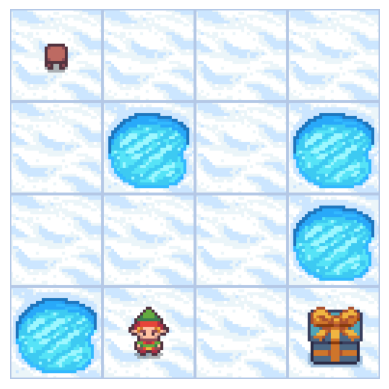

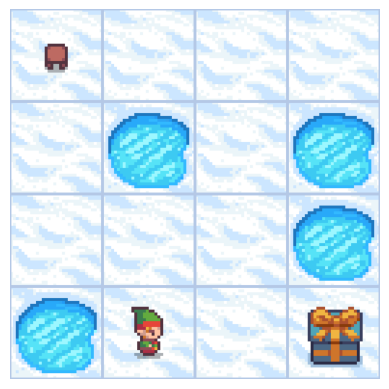

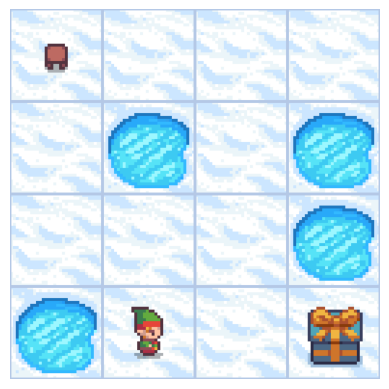

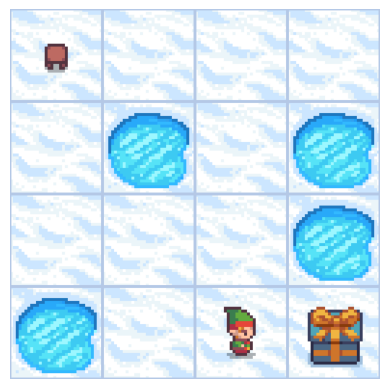

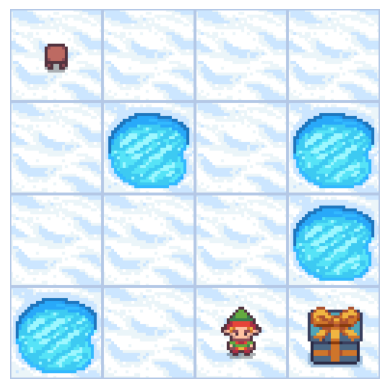

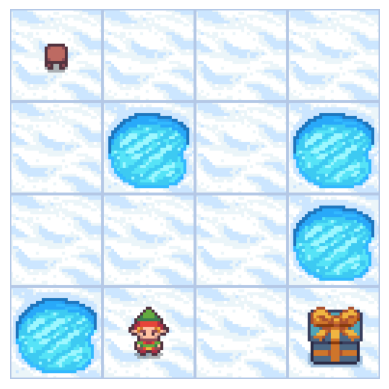

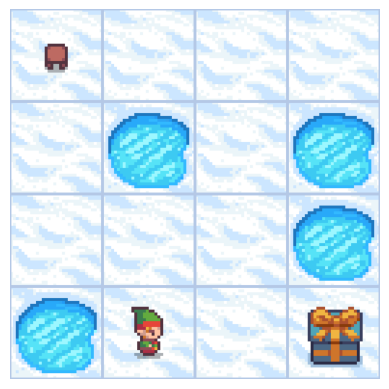

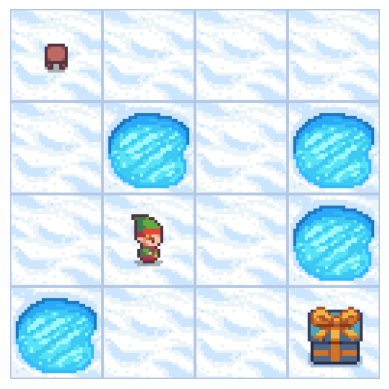

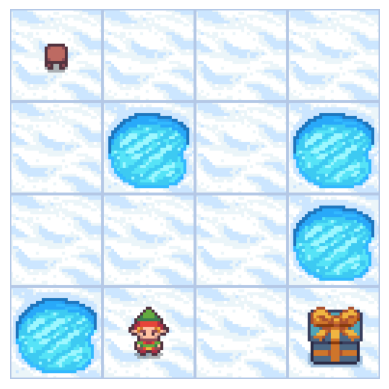

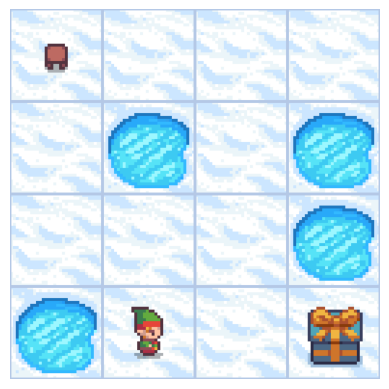

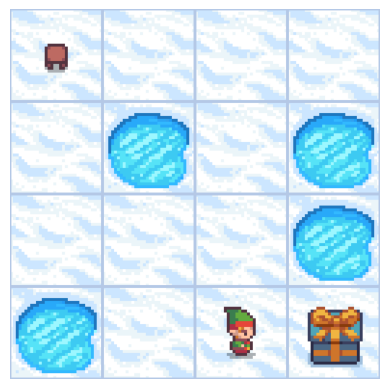

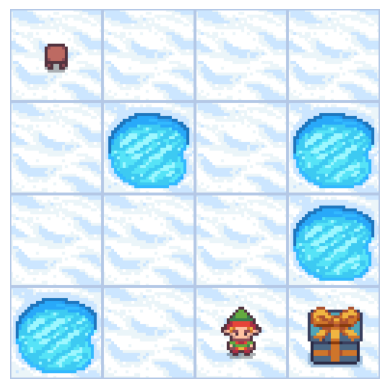

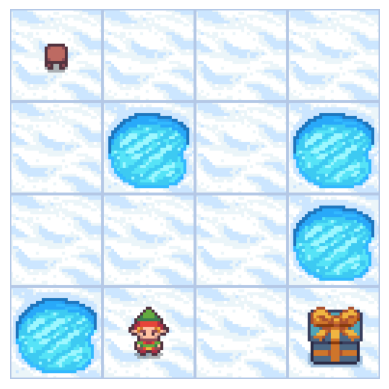

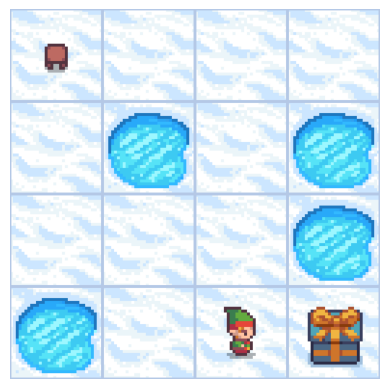

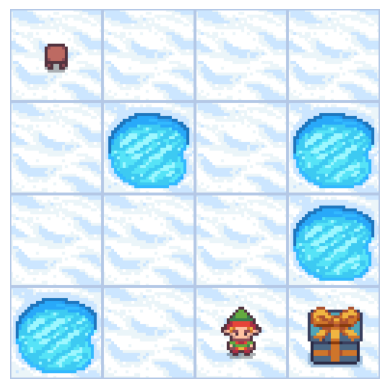

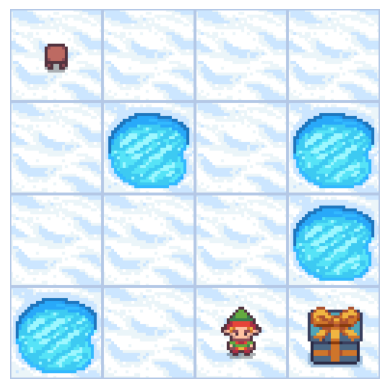

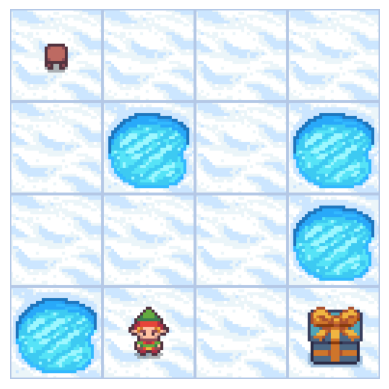

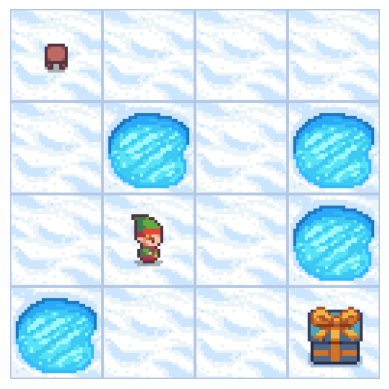

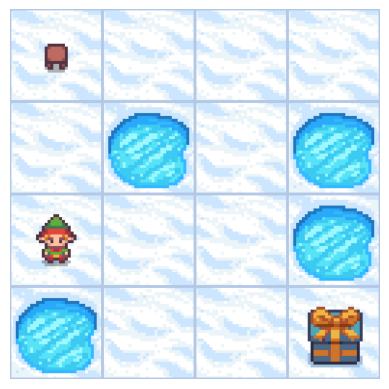

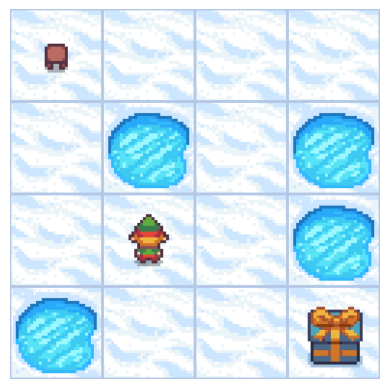

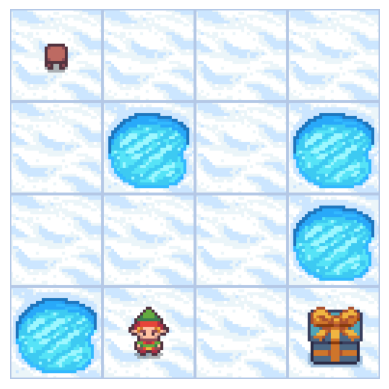

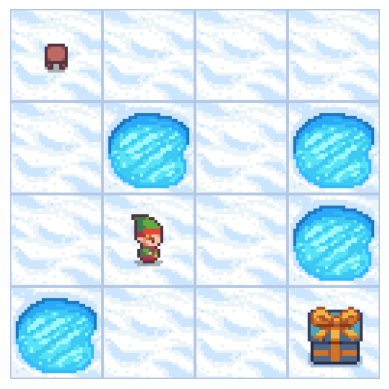

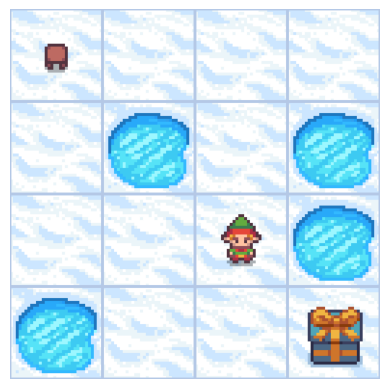

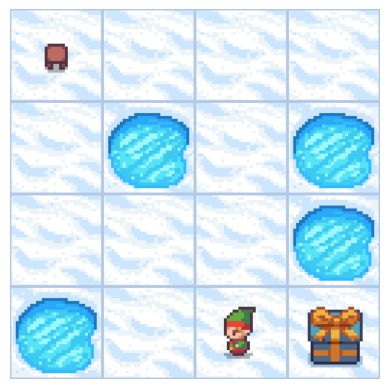

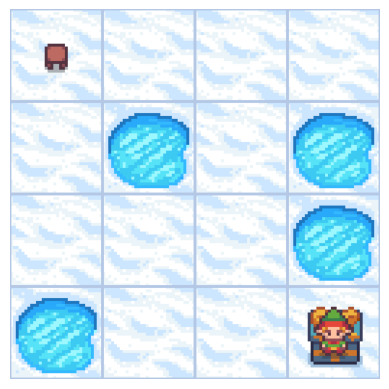

Гра завершена! Оцінка: 1.0

=== Висновки ===
1. Ітерація за цінністю швидше збігається до оптимального рішення, особливо для малих середовищ.
2. Ітерація за політиками може бути простішою у реалізації, оскільки оцінює лише політики, а не всю функцію цінності.
3. Обидва методи приводять до однакових оптимальних політик у задачах з дискретними станами, такими як 'Frozen Lake'.


In [16]:
import gym
import numpy as np
import matplotlib.pyplot as plt

def show_render(img):
    # Перевіряємо, чи img є списком зображень
    if isinstance(img, list):
        img = img[0]  # Вибираємо перше зображення зі списку

    # Перевірка на розміри та формат зображення
    if img.ndim == 4:
        img = img[0]  # Якщо зображення є батчем (масив з кількох зображень), вибираємо перший елемент

    # Видаляємо зайві виміри
    img = np.squeeze(img)
    if img.ndim == 3 and img.shape[-1] == 3:  # Якщо зображення має канали RGB
        img = img[..., :3]  # Вибираємо тільки перші три канали (RGB)

    plt.imshow(img)
    plt.axis('off')  # Вимкнути вісі
    plt.show()




# Створюємо середовище задачі про замерзле озеро з новим API
env = gym.make(
    'FrozenLake-v1',
    desc=None,
    map_name="4x4",
    is_slippery=True,
    render_mode="rgb_array",
    new_step_api=True
)

# Функція для вибору випадкових дій
def random_policy(env):
    return np.random.choice(env.action_space.n)

# Функція ітерації за цінністю
def value_iteration(env, gamma=1.0):
    value_table = np.zeros(env.observation_space.n)
    no_of_iterations = 100000
    threshold = 1e-20

    for i in range(no_of_iterations):
        updated_value_table = np.copy(value_table)

        for state in range(env.observation_space.n):
            Q_value = []
            for action in range(env.action_space.n):
                next_states_rewards = []
                for next_sr in env.P[state][action]:
                    trans_prob, next_state, reward_prob, _ = next_sr
                    next_states_rewards.append((trans_prob * (reward_prob + gamma * updated_value_table[next_state])))

                Q_value.append(np.sum(next_states_rewards))

            value_table[state] = max(Q_value)

        if (np.sum(np.fabs(updated_value_table - value_table)) <= threshold):
            print(f'Value-iteration converged at iteration# {i + 1}.')
            break

    return value_table

# Функція отримання політики з функції цінності
def extract_policy(value_table, gamma=1.0):
    policy = np.zeros(env.observation_space.n)

    for state in range(env.observation_space.n):
        Q_table = np.zeros(env.action_space.n)

        for action in range(env.action_space.n):
            for next_sr in env.P[state][action]:
                trans_prob, next_state, reward_prob, _ = next_sr
                Q_table[action] += (trans_prob * (reward_prob + gamma * value_table[next_state]))

        policy[state] = np.argmax(Q_table)

    return policy

# Функція ітерації за політиками
def policy_iteration(env, gamma=1.0):
    def compute_value_function(policy, gamma):
        value_table = np.zeros(env.observation_space.n)
        threshold = 1e-10

        while True:
            updated_value_table = np.copy(value_table)

            for state in range(env.observation_space.n):
                action = policy[state]
                value_table[state] = sum([trans_prob * (reward_prob + gamma * updated_value_table[next_state])
                                          for trans_prob, next_state, reward_prob, _ in env.P[state][action]])

            if np.sum(np.fabs(updated_value_table - value_table)) <= threshold:
                break

        return value_table

    policy = np.zeros(env.observation_space.n)

    for i in range(100000):
        new_value_function = compute_value_function(policy, gamma)
        new_policy = extract_policy(new_value_function, gamma)

        if np.array_equal(policy, new_policy):
            print(f'Policy-iteration converged at iteration# {i + 1}.')
            break

        policy = new_policy

    return policy

# Функція для виконання політики в середовищі
def run_policy(env, policy):
    obs = env.reset()  # Ініціалізація середовища, отримуємо тільки стан
    done = False
    total_reward = 0

    while not done:
        action = int(policy[obs])  # Вибір дії з політики на основі поточного стану
        obs, reward, done, truncated, info = env.step(action)  # Виконання дії
        total_reward += reward  # Додавання винагороди

        img = env.render()  # Отримуємо зображення
        show_render(img)  # Відображаємо зображення

        if done:
            print(f"Гра завершена! Оцінка: {total_reward}")
            break


# Візуалізація початкового стану середовища
print("\n=== Початковий стан середовища ===")
obs = env.reset()  # Ініціалізуємо середовище і отримуємо перший стан
start_img = env.render()  # Отримуємо зображення
show_render(start_img)  # Відображаємо зображення

# Виконання кількох кроків з випадковими діями
print("\n=== Виконання випадкових дій ===")
for _ in range(20):  # Виконати 20 кроків
    action = random_policy(env)  # Вибір випадкової дії
    obs, reward, done, truncated, info = env.step(action)  # Виконання дії
    img = env.render()  # Отримуємо зображення
    show_render(img)  # Відображаємо зображення
    if done:
        break  # Завершити гру, якщо це кінець

# Виконання ітерації за цінністю
print("\n=== Ітерація за цінністю ===")
optimal_value_function = value_iteration(env=env, gamma=1.0)
optimal_policy_vi = extract_policy(optimal_value_function, gamma=1.0)
print("Оптимальна функція цінності:")
print(optimal_value_function)
print("Оптимальна політика:")
print(optimal_policy_vi)

# Візуалізація після ітерації за цінністю
print("\n=== Середовище після ітерації за цінністю ===")
obs = env.reset()  # Потрібно ініціалізувати знову
value_img = env.render()  # Отримуємо зображення
show_render(value_img)  # Відображаємо зображення

# Виконання ітерації за політиками
print("\n=== Ітерація за політиками ===")
optimal_policy_pi = policy_iteration(env=env, gamma=1.0)
print("Оптимальна політика:")
print(optimal_policy_pi)

# Візуалізація після ітерації за політиками
print("\n=== Середовище після ітерації за політиками ===")
obs = env.reset()  # Потрібно ініціалізувати знову
policy_img = env.render()  # Отримуємо зображення
show_render(policy_img)  # Відображаємо зображення

# Виконання оптимальної політики
print("\n=== Виконання оптимальної політики ===")
run_policy(env, optimal_policy_pi)

# Висновки
print("\n=== Висновки ===")
print("1. Ітерація за цінністю швидше збігається до оптимального рішення, особливо для малих середовищ.")
print("2. Ітерація за політиками може бути простішою у реалізації, оскільки оцінює лише політики, а не всю функцію цінності.")
print("3. Обидва методи приводять до однакових оптимальних політик у задачах з дискретними станами, такими як 'Frozen Lake'.")
